In [40]:
import pandas as pd
from functions import specific_processes

### 入出力データセットの名称
## 入力データ
train_file = 'train.csv'
test_file = 'test.csv'

### データのインポート
df_train = pd.read_csv('original_data/' + train_file)
df_test = pd.read_csv('original_data/' + test_file)
original_datasets = [df_train, df_test]

### データ加工の実施
model_input_datasets = []
model_input_datasets.append(specific_processes.pattern_1(*original_datasets))
model_input_datasets.append(specific_processes.pattern_2(*original_datasets))
model_input_datasets.append(specific_processes.pattern_3(*original_datasets))

ModuleNotFoundError: No module named 'general_processes'

In [ ]:
## 準備
i = 2
model_name = 'newral_network'
response_variable_name = 'Survived'

x_train_val = model_input_datasets[i][0]
y_train_val = model_input_datasets[i][1]
x_test = model_input_datasets[i][2]
id_test = model_input_datasets[i][3] # for submitting result

# ## boolをintに変換する
# x_train_val = specific_processes.bool_to_int(x_train_val)
# x_test = specific_processes.bool_to_int(x_test)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler

In [30]:
# データの分割
x_train,x_val,y_train,y_val = train_test_split(\
    x_train_val, y_train_val, test_size=0.3, random_state=0\
      )

# データの標準化
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

In [31]:
# モデルの構築
model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_val.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # バイナリ分類なのでsigmoid
])

/Users/keitaoikoshi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [32]:
# コンパイルと学習
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5742 - loss: 0.7185 - val_accuracy: 0.7724 - val_loss: 0.5166
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7333 - loss: 0.5808 - val_accuracy: 0.8060 - val_loss: 0.4645
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7317 - loss: 0.5309 - val_accuracy: 0.7985 - val_loss: 0.4377
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7797 - loss: 0.5001 - val_accuracy: 0.8284 - val_loss: 0.4222
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7936 - loss: 0.4756 - val_accuracy: 0.8321 - val_loss: 0.4151
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8165 - loss: 0.4594 - val_accuracy: 0.8321 - val_loss: 0.4087
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8250 - loss: 0.4216 - val_accuracy: 0.8246 - val_loss: 0.4028
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8337 - loss: 0.4088 - val_accuracy: 0.8358 - val_loss:

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Validation Accuracy: 0.8284


<Axes: >

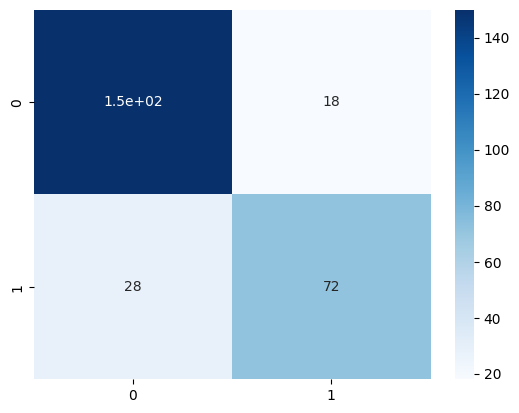

In [33]:
# 精度確認
y_val_pred = (model.predict(x_val) > 0.5).astype(int)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# 混同行列を表示
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_val,y_val_pred)
sns.heatmap(cm, annot=True, cmap='Blues')

In [34]:
# 解釈
from sklearn.metrics import accuracy_score
import numpy as np

def permutation_importance(model, x_val, y_val, metric=accuracy_score):
    baseline = metric(y_val, (model.predict(x_val) > 0.5).astype(int))
    importances = []
    
    for i in range(x_val.shape[1]):
        x_val_ = x_val.copy()
        np.random.shuffle(x_val_[:, i])  # i番目の特徴をシャッフル
        score = metric(y_val, (model.predict(x_val_) > 0.5).astype(int))
        importances.append(baseline - score)
    
    return np.array(importances)

importances = permutation_importance(model, x_val, y_val)

# 特徴量名とセットで表示
feature_names = x_train_val.columns.tolist()
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s

In [38]:
# 予測実行
y_test_pred = (model.predict(x_test) > 0.5).astype(int)
df_result = pd.concat([id_test, \
                       pd.DataFrame(y_test_pred, columns=[response_variable_name])], \
                        axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


In [39]:
### 8. 結果の出力
result_file_name = 'outputs/' + model_name + '_' + str(i+1) + '.csv'
df_result.to_csv(result_file_name, index=False)

In [36]:
# from keras.layers import Dense, Dropout
# from keras.models import Sequential
# from sklearn.metrics import log_loss
# from sklearn.preprocessing import StandarScaler

# # データの分割
# from sklearn.model_selection import train_test_split
# # データを学習用、検証用に分割する(乱数シードを0、検証データの割合を0.3に指定)
# x_train,x_val,y_train,y_val = train_test_split(\
#     x_train_val, y_train_val, test_size=0.3, random_state=0\
#       )

# # データのスケーリング
# scaler = StandarScaler()
# x_train = scaler.fit_transform(x_train)
# x_val = scaler.transform(x_val)
# x_test = scaler.transform(x_test)

# # ニューラルネットモデルの構築
# model = Sequential()
# model.add()